In [1]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'
DATA_PATH_BYD = '../bds/BYDDY.csv'


In [2]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

In [4]:
# acf, ci = sm.tsa.acf(endog, alpha=0.05)
def getSignificantLags(y, nLags = 5, alpha=0.05):
    pac, pac_ci = sm.tsa.pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    significantLags = []
    for i in range(1, len(pac)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags

def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df

significantLags: [1, 5, 8, 10]


,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10)
10,2020-09-16,147.253326,149.919998,122.093330,135.666672,158.350006
11,2020-09-17,141.143326,147.253326,123.779999,139.440002,149.123337


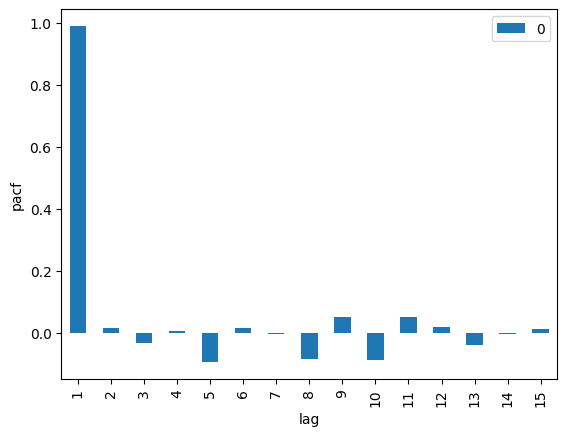

In [5]:
tesla_significantLags = getSignificantLags(y=TESLA['Close'], nLags = 15, alpha=0.05)

TM_tesla = appendLagVariables(yNm='Close', significantLags = tesla_significantLags, df = TESLA, dropna=True)

In [6]:
df_tesla = TM_tesla.dropna()
# Separar features e target
X = df_tesla.drop('Close', axis=1)
X = X.drop('Date', axis=1)
y = df_tesla['Close']
# Dividir os dados em treino e teste
X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla = train_test_split(X, y, test_size=0.2, shuffle=False)